# Imports

In [1]:
import sys
sys.path.append("../../src/")
from ECALDataAnalyzer import ECALDataAnalyzer
from TrainData import TrainData
from model_functions import make_gravnet_model
from condensation_loss import custom_loss, attractive_loss_metric, repulsive_loss_metric, coward_loss_metric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
import pandas as pd

from object_condensation.tensorflow.losses import (
    condensation_loss,
)

import numpy as np
import os
import tensorflow as tf

2024-08-14 12:29:51.499005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 12:29:51.630706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2024-08-14 12:29:51.630735: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-14 12:29:52.353826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared objec

# Load and Plot Data

In [2]:
directory = '../../projects/test.epn.08.12.2024.21.50/training'
all_files = [directory+"/"+file for file in os.listdir(directory)]
original_files     = sorted([file for file in all_files if "-intersections.csv" not in file])

# Load in Training Data

In [6]:
data = TrainData(csv_files = original_files,
                 train_size = 0.8,
                 return_tensor = True,
                 K=20)

train_X, train_y, train_misc = data.get_train_data()
test_X, test_y, test_misc = data.get_test_data()

100%|████████████████████████████████████████| 362/362 [00:10<00:00, 34.01it/s]


Total files processed: 362


# Initialize Model

In [9]:
batch_size = 128       # Batch size
learning_rate = 0.001  # Learning rate
N_epochs   = 100       # Number of epochs to train

model = make_gravnet_model()

# Obtain a tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y, train_misc))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile model
model.compile(optimizer=optimizer, 
              loss=custom_loss,
              metrics=[attractive_loss_metric, repulsive_loss_metric, coward_loss_metric])

# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Training

In [10]:
model.fit(x=train_X,
          y=train_y,
          batch_size=batch_size,
          epochs=N_epochs,
          validation_data=(test_X, test_y),
          callbacks=[early_stopping_callback])

Epoch 1/100
59/59 [==============================] - 6s 46ms/step - loss: 0.7237 - attractive_loss_metric: 0.2163 - repulsive_loss_metric: 0.0229 - coward_loss_metric: 0.4806 - val_loss: 0.4981 - val_attractive_loss_metric: 0.0169 - val_repulsive_loss_metric: 0.0151 - val_coward_loss_metric: 0.4655
Epoch 2/100
59/59 [==============================] - 2s 33ms/step - loss: 0.3895 - attractive_loss_metric: 0.0908 - repulsive_loss_metric: 0.0341 - coward_loss_metric: 0.2634 - val_loss: 0.4437 - val_attractive_loss_metric: 0.0156 - val_repulsive_loss_metric: 0.0300 - val_coward_loss_metric: 0.3972
Epoch 3/100
59/59 [==============================] - 2s 33ms/step - loss: 0.3160 - attractive_loss_metric: 0.0685 - repulsive_loss_metric: 0.0404 - coward_loss_metric: 0.2067 - val_loss: 0.4147 - val_attractive_loss_metric: 0.0181 - val_repulsive_loss_metric: 0.0455 - val_coward_loss_metric: 0.3498
Epoch 4/100
59/59 [==============================] - 2s 33ms/step - loss: 0.2796 - attractive_loss_m

# Evaluating

In [11]:
evaluator = Evaluator(test_X, test_y, test_misc)
evaluator.load_model(model)
evaluator.predict()
evaluator.cluster(0.7,0.3)

225/225 [==============================] - 1s 2ms/step


100%|█████████████████████████████████████| 7180/7180 [00:19<00:00, 371.60it/s]


# Plotting

array([<Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='Learned $\\beta$'>], dtype=object)

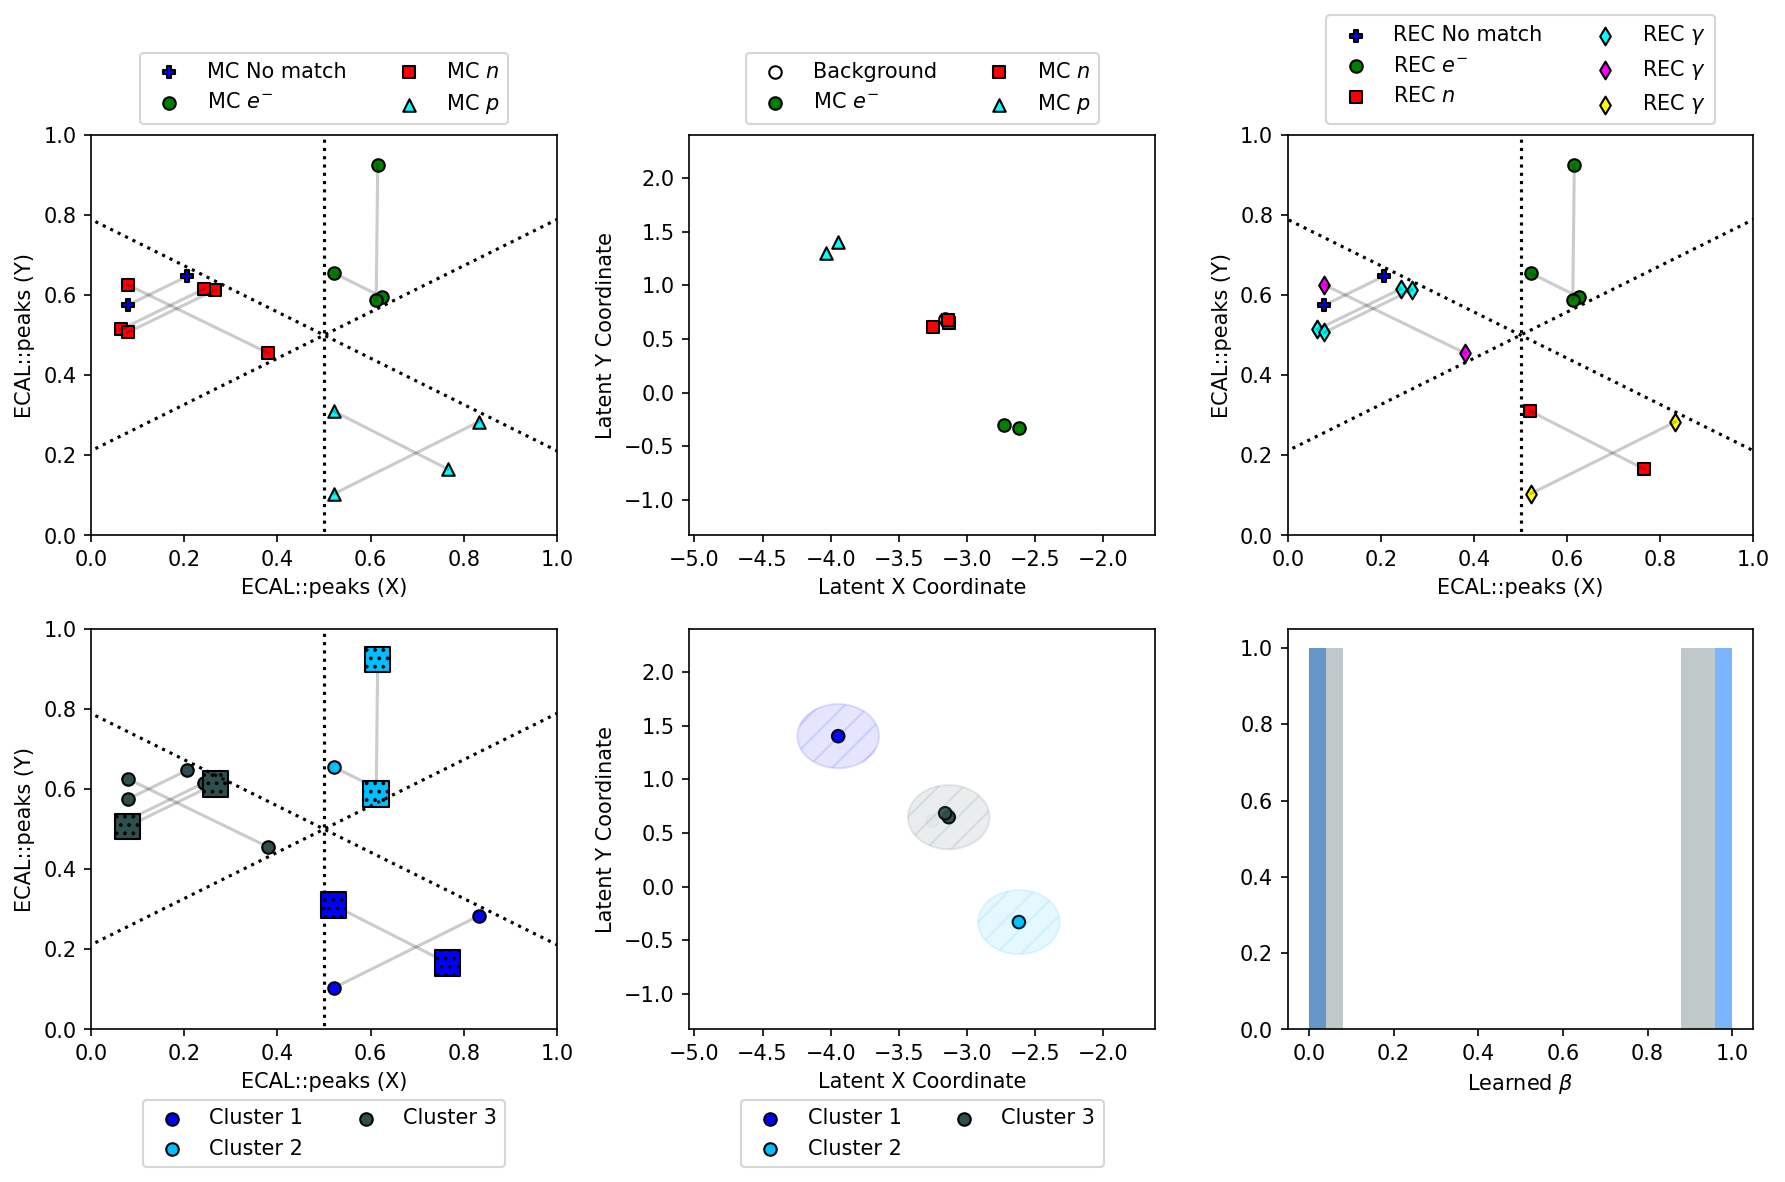

In [14]:
plotter = ModelEcalPlotter(evaluator.get_event_dataframe())
plotter.plot_all(tD=evaluator.tD)